In [2]:
#import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import OrderedDict

import re
import os
import math
import csv
from scipy import stats
import time
import numpy as np

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance as dist

import scipy.cluster
import fastcluster
import csv
import json
from scipy import sparse

import random

from sklearn.cluster import KMeans

import seaborn as sns; sns.set()

# alt.renderers.enable('notebook')
pd.set_option('display.max_columns', None)
import re

# nltk.download('wordnet')
# nltk.download('punkt')
# from gensim.models import Word2Vec

from nltk.cluster import KMeansClusterer
# import gensim
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import stem
#from textblob import Word

# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200

from scipy.stats import spearmanr
from scipy.stats import norm

from scipy.stats import pearsonr


In [3]:
# utils
#util functions
def createTableDic(dicID, filename):
    '''
    '''
    data = pd.read_csv(filename, encoding = 'utf-8')
    dataDic = {}
    column_list = data.columns.values.tolist()
    for i in range(len(data)):
        dataID = data.loc[i,dicID]
        if(dataID in dataDic):
            dataInfo = {}
            for key in column_list:
                dataInfo[key] = data.loc[i,key]
            dataDic[dataID].append(dataInfo)
        else:
            dataInfo = {}
            for key in column_list:
                dataInfo[key] = data.loc[i,key]
            dataDic[dataID] = [dataInfo]
    return dataDic  

def createTableDicTwo(dicID1, dicID2, filename):
    data = pd.read_csv(filename, encoding = 'utf-8')
    dataDic = {}
    column_list = data.columns.values.tolist()
    for i in range(len(data)):
        dataID1 = data.loc[i,dicID1]
        dataID2 = data.loc[i,dicID2]
        dataID = str(dataID1) + '-' + str(dataID2)
        if(dataID in dataDic):
            dataInfo = {}
            for key in column_list:
                dataInfo[key] = data.loc[i,key]
            dataDic[dataID].append(dataInfo)
        else:
            dataInfo = {}
            for key in column_list:
                dataInfo[key] = data.loc[i,key]
            dataDic[dataID] = [dataInfo]
    return dataDic

def count_unique_terms(word_list):
    return len(list(set(word_list)))
    

#### map bimedical descriptions to UMLS semantic concepts

##### parse UMLS table

* create the dictionary of UMLS IDs and text

In [6]:
def parse_UMLS_table(filename):
    try:
        f = open(filename, 'r') 
        content=f.readlines() 
        table_list = []
        st_dic = {}
        st_tnum_dic = {}
        for index, item in enumerate(content):
            row = item.lstrip().replace('\n','').split('|')
            table_dic = {}
            table_dic['acro'] = row[0]
            table_dic['full_name'] = row[2]
            st_dic[row[0]] = row[2]
            st_tnum_dic[row[1]] = row[2]
            table_list.append(table_dic)
        df = pd.DataFrame(table_list)
        return st_dic, st_tnum_dic
        
    finally:
        if f:
            f.close()
            
st_dic, st_tnum_dic = parse_UMLS_table("/home/jian/mengling/TobaccoResearch/TobaccoControl/OntologyKB/SemanticTypes_2018AB.txt")

st_tnum_dic

{'T116': 'Amino Acid, Peptide, or Protein',
 'T020': 'Acquired Abnormality',
 'T052': 'Activity',
 'T100': 'Age Group',
 'T087': 'Amino Acid Sequence',
 'T011': 'Amphibian',
 'T190': 'Anatomical Abnormality',
 'T008': 'Animal',
 'T017': 'Anatomical Structure',
 'T195': 'Antibiotic',
 'T194': 'Archaeon',
 'T123': 'Biologically Active Substance',
 'T007': 'Bacterium',
 'T031': 'Body Substance',
 'T022': 'Body System',
 'T053': 'Behavior',
 'T038': 'Biologic Function',
 'T012': 'Bird',
 'T029': 'Body Location or Region',
 'T091': 'Biomedical Occupation or Discipline',
 'T122': 'Biomedical or Dental Material',
 'T023': 'Body Part, Organ, or Organ Component',
 'T030': 'Body Space or Junction',
 'T026': 'Cell Component',
 'T043': 'Cell Function',
 'T025': 'Cell',
 'T019': 'Congenital Abnormality',
 'T103': 'Chemical',
 'T120': 'Chemical Viewed Functionally',
 'T104': 'Chemical Viewed Structurally',
 'T185': 'Classification',
 'T201': 'Clinical Attribute',
 'T200': 'Clinical Drug',
 'T077': '

##### pre-processing data

###### stop words

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer() 

stopwords = stopwords.words('english')
stopwords.append("i've")
stopwords.append("that's")
stopwords.append("we're")
stopwords.append("i'm")
stopwords.append("was")
stopwords.append("were")
stopwords.append("they're")
stopwords.append("can't")
stopwords.append("like")
stopwords.append("you're")
stopwords.append("there's")
stopwords.append("'m")
stopwords.append("I'd")
stopwords


[nltk_data] Downloading package stopwords to /home/jian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
def metaMap_preprocessing(sent):
    sent = re.split(' |,|\.', sent)
    sent_clean = []
    for token in sent:
        #print(token)
        if token.lower() not in stopwords:
            sent_clean.append(token)
    sent = ' '.join(sent_clean)
    sent = ' '.join(sent.split())
    sent.replace('，', ',')
    sent = sent.title()
    sent = sent + '.'
    #print(sent)
    return sent

def metaMap_preprocessing_v2(sent):
    sent_clean = re.split(' |,|\.', sent)
    target_token = []
    #print(sent_clean)
    for token in sent_clean:
        lower_token = token.lower()
        if lower_token in stopwords:
            target_token.append(token)
    target_token = sorted(target_token, key=len, reverse=True) #make sure to matching the long terms first
    for token in target_token:
        #print(token)
        sent = re.sub(rf"\b{token}\b", '', sent)
    sent = ' '.join(sent.split())
    sent = sent.title()
    return sent


sentence = "Alright, so this was also on a like an eight multiply eleven type of wide frame. Inside, on the bottom of the page, looks like more of a geographic map with different layers of elevation lines were linear white. There's also a gray line sitting on the bottom that surrounds the structures around it. Above that, there's a 3D picture. It looks like it's a typogram or 3D remodeling of this figure. It's beige and has multiple dotted-like lines. It's more rounded, and it looks like it has like a base."
metaMap_preprocessing_v2(sentence)

'Alright, Also Eight Multiply Eleven Type Wide Frame. Inside, Bottom Page, Looks Geographic Map Different Layers Elevation Lines Linear White. Also Gray Line Sitting Bottom Surrounds Structures Around . , 3D Picture. Looks Typogram 3D Remodeling Figure. Beige Multiple Dotted- Lines. Rounded, Looks Base.'

##### metaMap

https://metamap.nlm.nih.gov/Installation.shtml

https://metamap.nlm.nih.gov/MainDownload.shtml

**to use metaMap, first we need to initialize the database server**

* cd to public_mm
* bin/skrmedpostctl start
* bin/wsdserverctl start 
* bin/metamap18  

**output format**

https://metamap.nlm.nih.gov/Docs/MMI_Output_2016.pdf

**parameters explanation**

https://metamap.nlm.nih.gov/Docs/MM_2016_Usage.pdf

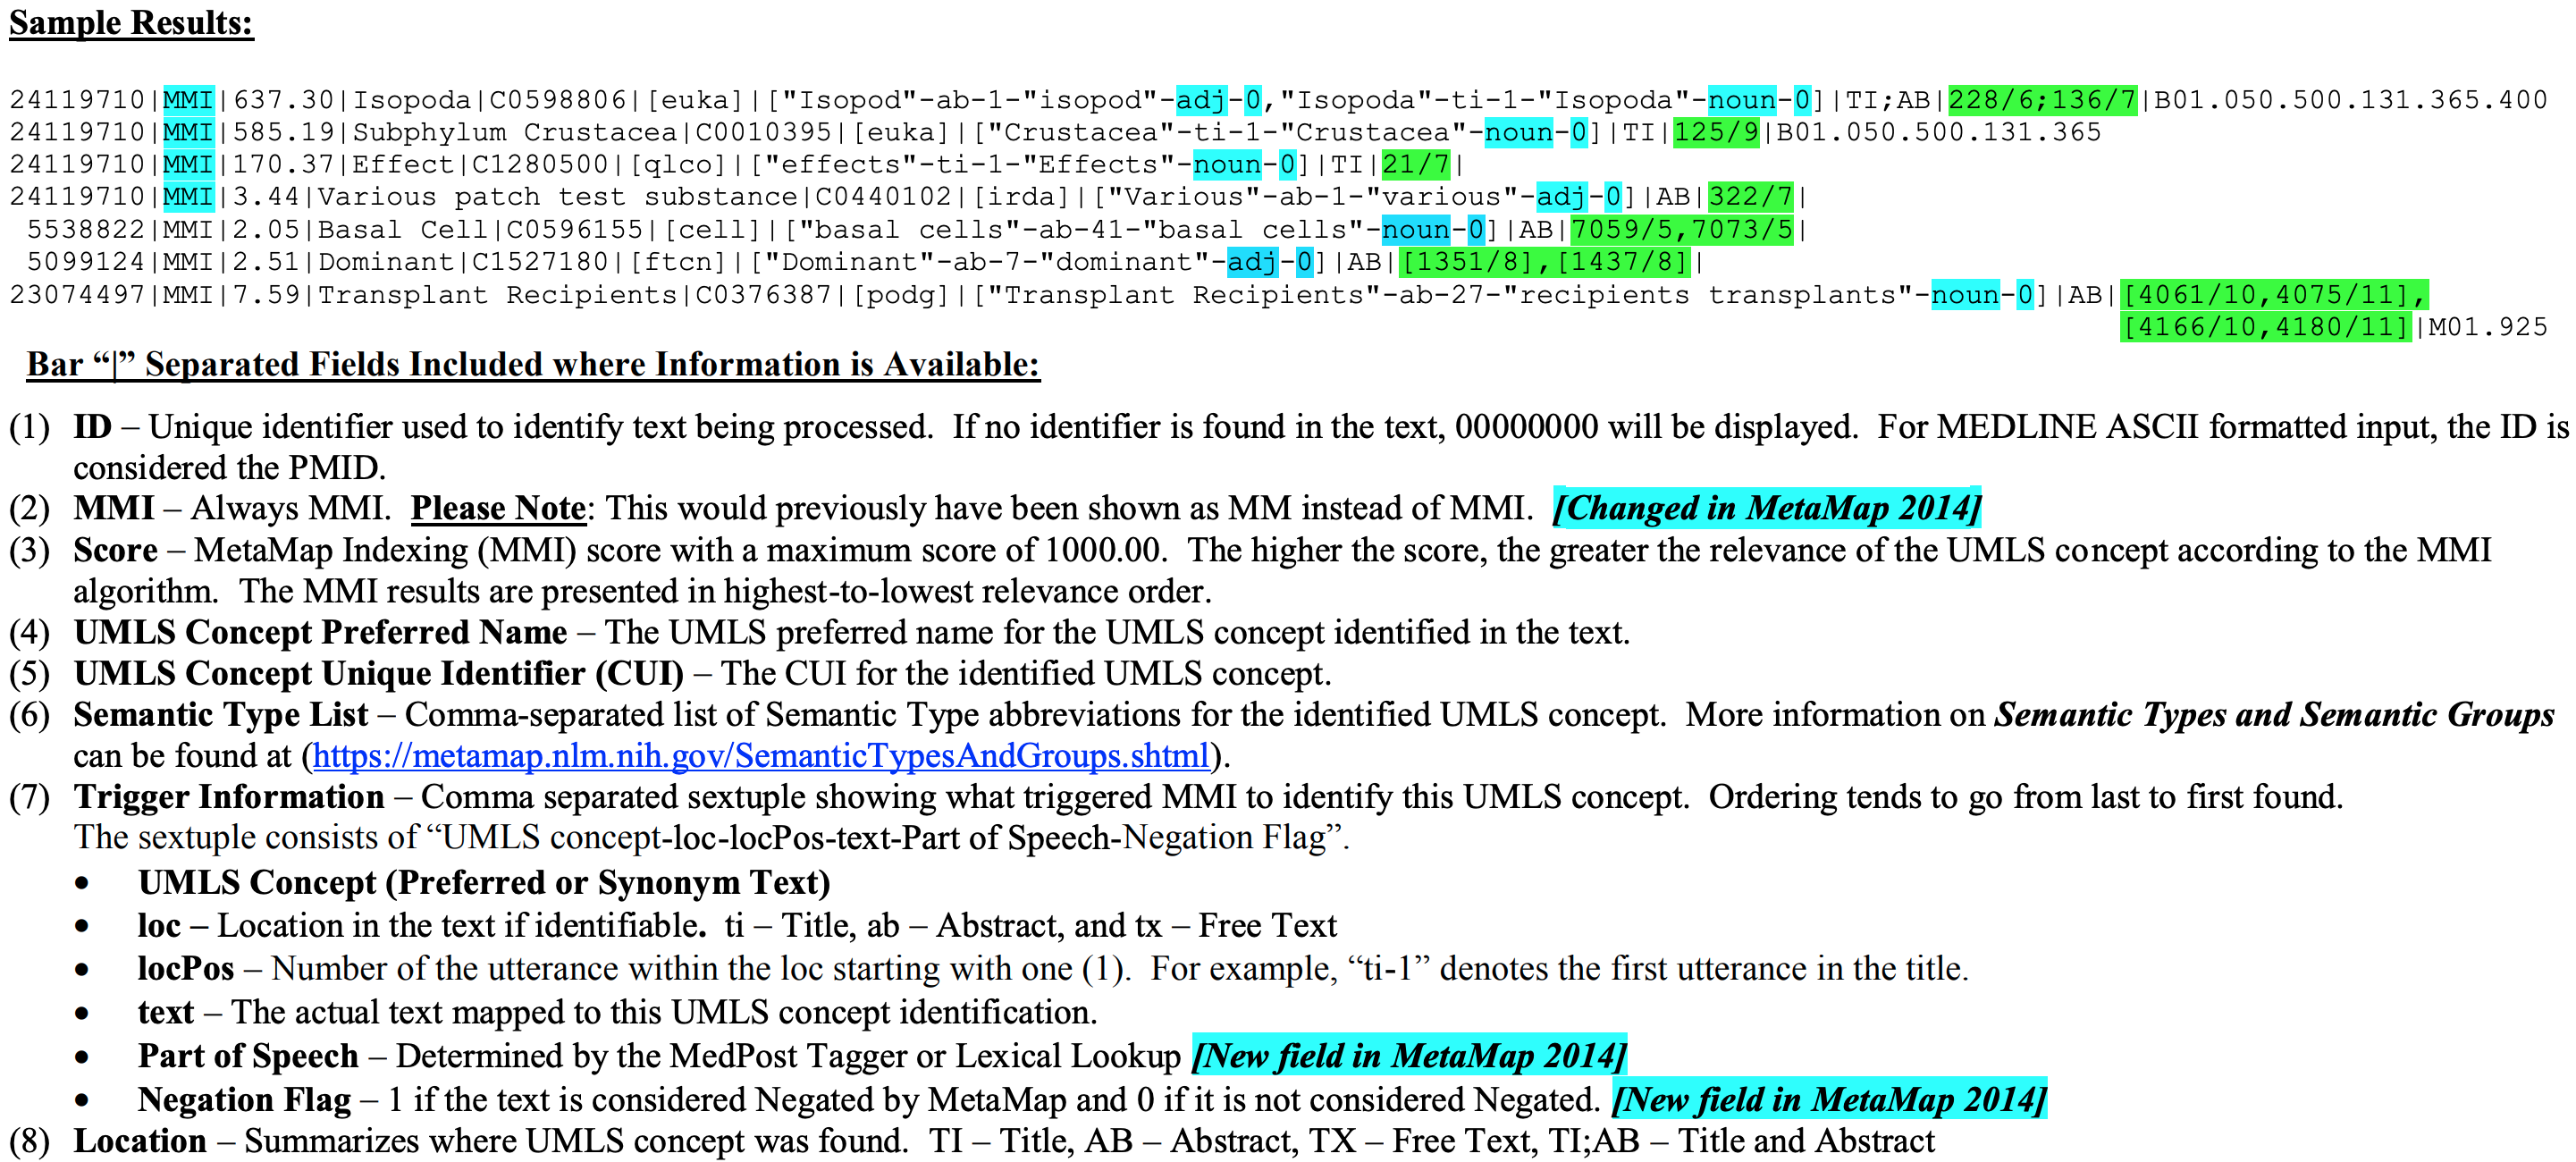


* metaMap lite documentation: https://metamap.nlm.nih.gov/Docs/README_MetaMapLite_3.6.2rc5.html

##### metaMapLite

In [9]:
##This section used subprocess to conduct the bash command
import subprocess
import os

In [10]:
# try the following in shell to make sure it works
# echo 'asymptomatic patient populations' | ./metamaplite.sh --pipe
# echo "inside" | ./metamaplite.sh --pipe

In [11]:
# from pymetamap import MetaMap
from pymetamap import MetaMapLite

In [15]:
mm = MetaMapLite.get_instance('/home/jian/mengling/public_mm_lite/') #metamap lite

In [16]:
sents = ["Inside it, That was sort of a rounded mass of multiple short black lines with white spaces in between almost looked like hair."]
sents = [metaMap_preprocessing_v2(sents[0])]
print(sents[0])
#print(metaMap_preprocessing(sents[0]))
concepts,error = mm.extract_concepts(sents,[1])
print(concepts, error)

Inside , Sort Rounded Mass Multiple Short Black Lines White Spaces Almost Looked Hair.
[] None


###### An example shows how to extract concepts

In [10]:
for concept in concepts:
    print(concept)
    trigger = concept.trigger
    trigger = trigger[1:][:-1].split(',\"')
    trigger = trigger[0].split('-')
    #print("after split", trigger)
    original_term = trigger[-3].replace('\"','')
    matched_term = concept.preferred_name
    umls_concept = trigger[0]
    semantic_type = concept.semtypes[1:][:-1].split(',')[0]
    semantic_type = st_dic[semantic_type]
    
    print("original_term",original_term, "matched_term",matched_term, \
          "umls_concept",umls_concept,"semantic_type", semantic_type, "score",concept.score)
    
    #print("original term:", concept.trigger.split('-')[3], ";matched term:", concept.preferred_name, \
          #";semantic type:", st_dic[concept.semtypes[1:][:-1]])
    #print(concept.cui, concept.preferred_name, concept.semtypes[1:][:-1], concept.trigger.split('-')[3], concept.score)

In [ ]:
def extract_UMLS_from_metaMapLite():
    '''
    note!!!!!! this one has to be in the same folder with the metaMapLite
    extract UMLS concepts from metaMapLite
    note that there is no word_sense_disambiguation module in metaMapLite, we need to check the score of these semantic types
    '''
    data = pd.read_csv('2020 09 19 merge terms.csv', encoding = 'utf-8')
    for i in range(len(data)):
        description = data.at[i,'description']
        description = [metaMap_preprocessing_v2(description)]
        concepts,error = mm.extract_concepts(description)
        print(i, description)
        
        original_terms = ''
        matched_terms = ''
        semantic_types = ''
        res = ''
        
        concepts_dic = {} #used to store all concepts, determine if the current terms already been included
        
        for concept in concepts:

            trigger = concept.trigger
            trigger = trigger[1:][:-1].split(',\"')
            trigger = trigger[0].split('-')
            original_term = trigger[-3].replace('\"','')
            matched_term = concept.preferred_name
            semantic_type = concept.semtypes[1:][:-1].split(',')[0]
            semantic_type = st_dic[semantic_type]
            score = concept.score
            
            if original_term not in concepts_dic:
                concept_info = {}
                concept_info['original_term'] = original_term
                concept_info['matched_term'] = matched_term
                concept_info['semantic_type'] = semantic_type
                concept_info['score'] = score
                concepts_dic[original_term] = [concept_info]
            else:
                #this term already existed
                concept_info = {}
                concept_info['original_term'] = original_term
                concept_info['matched_term'] = matched_term
                concept_info['semantic_type'] = semantic_type
                concept_info['score'] = score
                concepts_dic[original_term].append(concept_info)
            

        for key in concepts_dic:
            #print(key)
            original_terms = original_terms + concepts_dic[key][0]['original_term'] + '; ' 
            matched_terms = matched_terms + concepts_dic[key][0]['matched_term'] + '; ' 
            semantic_types = semantic_types + concepts_dic[key][0]['semantic_type'] + '; ' 
            
            #get the whole results
            if(res == ''):
                res = res + concepts_dic[key][0]['original_term'] + '; ' + \
                concepts_dic[key][0]['matched_term'] + '; ' + \
                concepts_dic[key][0]['semantic_type'] + '; ' + \
                concepts_dic[key][0]['score']
            else:
                res = res + '\n' + concepts_dic[key][0]['original_term'] + '; ' + \
                concepts_dic[key][0]['matched_term'] + '; ' + \
                concepts_dic[key][0]['semantic_type'] + '; ' + \
                concepts_dic[key][0]['score']
            
            if(len(concepts_dic[key]) > 1):
                for j in range(1, len(concepts_dic[key])):
                    res = res + '   ' + concepts_dic[key][j]['original_term'] + '; ' + \
                    concepts_dic[key][j]['matched_term'] + '; ' + \
                    concepts_dic[key][j]['semantic_type'] + '; ' + \
                    concepts_dic[key][j]['score']
                
               
        data.loc[i, 'UMLS_metaMapLite'] = res
        data.loc[i, 'UMLS_original_terms'] = original_terms[:-2]
        data.loc[i, 'UMLS_matched_terms'] = matched_terms[:-2]
        data.loc[i, 'UMLS_semantic_types'] = semantic_types[:-2]
        #print(original_terms)

        
    data.to_csv('test_res.csv',index=False, encoding='utf_8_sig')
    
extract_UMLS_from_metaMapLite()